In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
# 3

# Create ImageDataGenerator instances for train, validation, and test datasets.
# Rescale pixel values from [0, 255] → [0, 1].
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Generate batches of image data (and labels) directly from directory structures.
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'   # two classes: cats and dogs
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# For the test set: there are no subfolders (no labels).
# We use flow_from_directory trick by pointing to a parent folder and
# passing shuffle=False to preserve order.
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,                # parent folder that contains 'test'
    classes=['test'],              # explicitly choose only 'test' subfolder
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,               # no labels for test data
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


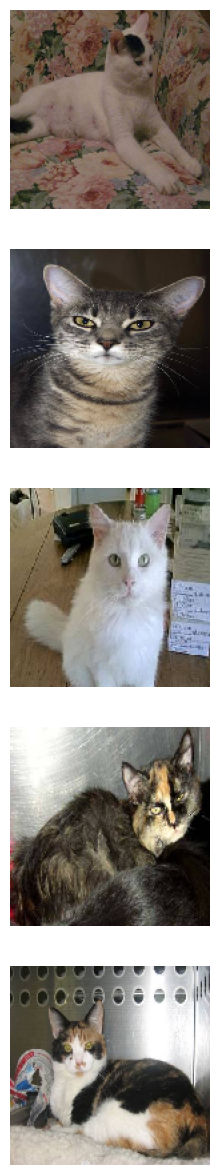

In [4]:
# Define a function to visualize a batch of images
def plotImages(images_arr, probabilities = False):
    # Create a figure with one subplot per image
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))

    # If no probabilities provided, just display images
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        # Display images with probability titles
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title("%.2f" % (probability*100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

# Extract one batch of training images and labels from the generator
sample_training_images, _ = next(train_data_gen)

# Plot first five images from that batch
plotImages(sample_training_images[:5])


In [5]:
# 5

train_image_generator = ImageDataGenerator(
    rescale=1./255,            # (1) normalization — always include this
    rotation_range=40,         # (2) random rotations up to 40 degrees
    width_shift_range=0.2,     # (3) horizontal shifts
    height_shift_range=0.2,    # (4) vertical shifts
    shear_range=0.2,           # (5) shear transformations
    zoom_range=0.2,            # (6) random zoom in/out
    horizontal_flip=True,      # (7) flip images horizontally
    fill_mode='nearest'        # handles empty pixels created by transformations
)




Found 2000 images belonging to 2 classes.


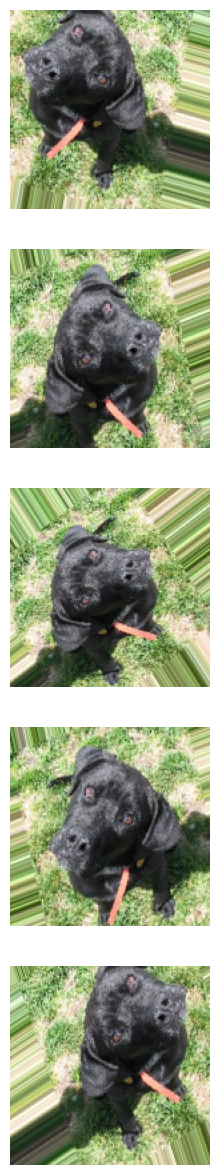

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7

model = Sequential([

    # --- Convolution + Pooling Layers ---
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    # --- Flatten + Dense Layers ---
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),                   # helps reduce overfitting
    Dense(1, activation='sigmoid')  # binary classification (cat vs. dog)
])

# --- Compile the Model ---
model.compile(
    optimizer='adam',                     # good general-purpose optimizer
    loss='binary_crossentropy',           # binary classification loss
    metrics=['accuracy']                  # track accuracy during training
)

# --- Show Model Summary ---
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 8

# Train the model using the fit method
history = model.fit(
    x=train_data_gen,                        # training data generator
    steps_per_epoch=total_train // batch_size,  # number of batches per epoch
    epochs=epochs,                           # how many times to go through the data
    validation_data=val_data_gen,            # validation data generator
    validation_steps=total_val // batch_size # number of validation batches per epoch
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4753 - loss: 1.0010 - val_accuracy: 0.5089 - val_loss: 0.6923
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4688 - loss: 0.6940

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.4688 - loss: 0.6940 - val_accuracy: 0.5346 - val_loss: 0.6925
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 931ms/step - accuracy: 0.5214 - loss: 0.6915 - val_accuracy: 0.5067 - val_loss: 0.6780
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5391 - loss: 0.6720 - val_accuracy: 0.6228 - val_loss: 0.6665
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5672 - loss: 0.6755 - val_accuracy: 0.6150 - val_loss: 0.6445
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5938 - loss: 0.6691 - val_accuracy: 0.6283 - val_loss: 0.6378
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 931ms/step - accuracy: 0.5861 - loss: 0.6559 - val_accuracy: 0.5904 - val_loss: 0.6395
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.6484 - loss: 0.6725 - val_accuracy: 0.5681 - val_loss: 0.6430
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 959ms/step - accuracy: 0.5798 - loss: 0.6598 - val_accuracy: 0.6462 - val

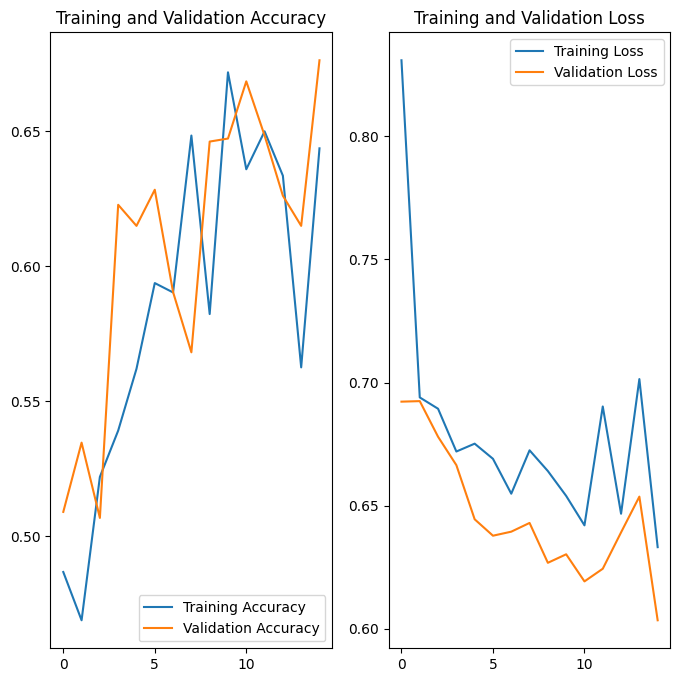

In [9]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/tmp/ipython-input-162682536.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")
/tmp/ipython-input-162682536.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")


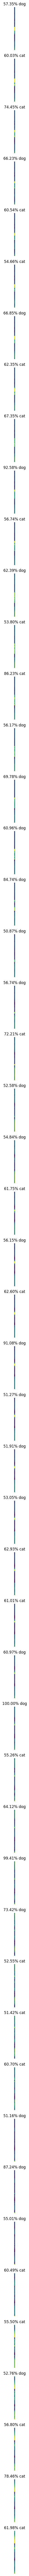

In [11]:
# 10

# Use the trained model to predict probabilities on the test dataset
probabilities = model.predict(test_data_gen)

# Visualize the test images with their predicted probabilities
plotImages(test_data_gen[0][0][:50], probabilities[:50])


In [18]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability[0]) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
